#**Deep Learning Homework 2: *Optimize and Train Deep Models***
### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---

In this homework, we will explore how to develop a simple Deep Neural Network for a classification problem. We will explore two common libraries: TensorFlow and Keras.
Then we will explore how to face a well known problem that is common to encounter during the training phase: the Overfitting.
Finally, we will study how to perform a fair model selection.
Hint: Before starting the exercise take a look at how Tensorflow and Keras are designed.  https://keras.io/

##Exercise 2.1: Text Classficiation with Tensorflow and Keras

In this first exercise we will develop a 3 layers Neural Network to perfrom classification.

Let's start importing the libraries we will need and setting a couple of environmental variables.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import tensorflow_datasets as tfds
import time

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

tf.random.set_seed(42)
# os.environ['TF_DETERMINISTIC_OPS']='1'

### Load Data: AG News Subset

In this HW, we use the AG News Subset that is available in Tensorflow Dataset. The AG's news topic classification dataset is constructed by choosing the 4 largest topic classes from a larger news corups. The total number of training samples is 120,000 and testing 7,600. Each class contains 30,000 training samples and 1,900 testing samples. Each sample contains both the title and an excerpt of the article, but in this exercise we will use only the excerpt as input.

We will split the training set into two 90%-10% splits in order to have a validation set.

In [3]:
### NOTE ### 
# running this cell might yield download-related errors.
# just repeating the execution a couple of times should solve the error.

train_ds, valid_ds, test_ds = tfds.load('ag_news_subset',
                                        as_supervised=True, # return a set of (text, label) tuples 
                                        split=['train[:90%]', 'train[-10%:]', 'test'],
                                        batch_size=-1)  
                                        # ^ using batch_size=-1 returns Tensors instead of Dataset objects

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteDQR8PB/ag_news_subset-train.tfrecord


  0%|          | 0/120000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteDQR8PB/ag_news_subset-test.tfrecord


  0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Tensors have two elements, data and labels; let's split them
# so we can transform the data
X_train, y_train = train_ds
X_valid, y_valid = valid_ds
X_test, y_test = test_ds

The AG News Subset dataset consists in news articles, each one composed by a sequence of words. In order to encode each article in a single tensor with a fixed number of elements, we will use multi-hot encoding. For testing purposes, we will only consider the first 10,000  most common words. Multi-hot-encoding our lists means turning them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. The obtained input representation indicates which words are present (at least one time) in the sentence.

In [5]:
num_words = 1000
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=num_words,
 standardize="lower_and_strip_punctuation",
 split="whitespace",
 output_mode='multi_hot',
 pad_to_max_tokens=True)

vectorize_layer.adapt(X_train)

In [6]:
X_train = vectorize_layer(X_train)
X_valid = vectorize_layer(X_valid)
X_test  = vectorize_layer(X_test)

### Define the model:

Let's build a Sequential model (`keras.models.Sequential`) and add four layers to it by calling its `add()` method:


*   a input layer (`tf.keras.Input`) that is the first layer in your model. With this layer you should specify the `input_shape` argument, leaving out the batch size: `(num_words,)`;
*  a Dense layer (`keras.layers.Dense`) with 16 neurons, and the "relu" activation function;
* another Dense layer with 16 neurons, also with the "relu" activation function;
* a final Dense layer with 4 output neurons, and with the "softmax" activation (since we considering a classification task with four classes).

In [7]:
model = keras.models.Sequential()
model.add(tf.keras.Input(shape=(num_words,)))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(4, activation="softmax"))

Call the model's `summary()` method to check if the model has been built correctly. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 16,356
Trainable params: 16,356
Non-trainable params: 0
_________________________________________________________________


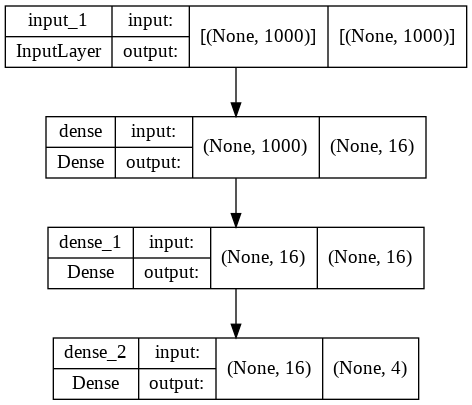

In [9]:
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

As you can see, the first dimension of each layer is not defined (`None`), indeed this dimension in each layer is variable and depends on the batch size.

Instaed of using `add()` method it is also possibile to define the model using the following syntax

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                16016     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 16,356
Trainable params: 16,356
Non-trainable params: 0
_________________________________________________________________


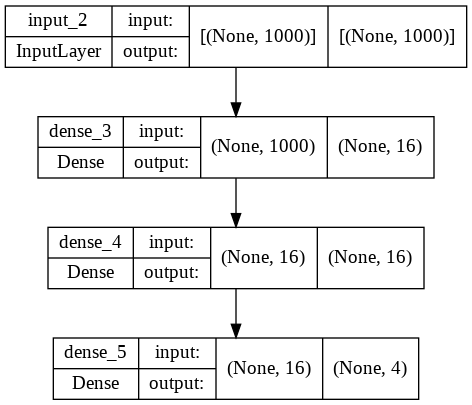

In [10]:
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])
model.summary()
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

### Optimize the model:

After the model has been created, you must call its `compile()` method to specify the loss function and the optimizer to use.

Since the model performs a classification task, and we have labels encoded as integers, we use the sparse categorical cross-entropy loss. As optimizer we use Adam.

Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case we specify `metrics=["accuracy"]`.

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

Now our model is ready to be trained. Call its `fit()` method, passing to it the input features (`X_train`) and the target classes (`y_train`). Set the number of epochs to 20. 
In order to validate our model we will also pass the validation data by setting `validation_data=(X_valid, y_valid)`. Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the loss on the training set is much lower than the one on the validation set, your model is probably overfitting the training set. Note: the `fit()` method will return a `History` object containing training stats.

In [12]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.8503 - accuracy: 0.6761 - val_loss: 0.5107 - val_accuracy: 0.8314
Epoch 2/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4583 - accuracy: 0.8449 - val_loss: 0.4452 - val_accuracy: 0.8475
Epoch 3/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4222 - accuracy: 0.8546 - val_loss: 0.4318 - val_accuracy: 0.8507
Epoch 4/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4089 - accuracy: 0.8573 - val_loss: 0.4241 - val_accuracy: 0.8509
Epoch 5/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4012 - accuracy: 0.8590 - val_loss: 0.4210 - val_accuracy: 0.8525
Epoch 6/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3959 - accuracy: 0.8601 - val_loss: 0.4175 - val_accuracy: 0.8531
Epoch 7/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3917 - accuracy: 0.8615 - val_loss: 0.4149 - val_accuracy:

Let's plot the loss and the accuracy trends on both training and validation sets. We define the `plot_learning_acc_and_loss` function because we will reuse it in the next steps.

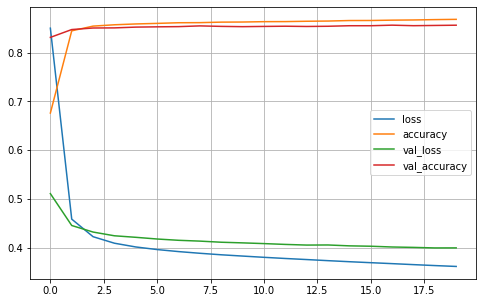

In [13]:
def plot_learning_acc_and_loss(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
plot_learning_acc_and_loss(history)

### [TO COMPLETE] Evaluate the model:

Now, our model has been optimized on the training set, and as you can see the performance on the validation set in quite similar (so it does not overfit the training data). Let's now evaluate the performance of our model using the test set.

In [14]:
model.evaluate(X_test, y_test)

238/238 [==============================] - 1s 2ms/step - loss: 0.4093 - accuracy: 0.8521


[0.40926671028137207, 0.8521052598953247]

[TO COMPLETE] Explain why it is important to use test and validation, and why it is important to evaluate the model on the test set instead of the validation set. Finally, explain what is the usefulness of the validation set. Insert the discussion in this cell.


__ANSWER:__ 

It is important to use test and validation set because we want to be sure that our model perform well also on data that it has not seen during training. This is important because the fact that our model has good performance on the training set, does not guarantee that it would be able to generalize well on new data.

The __validation__ set is used to tune the hyper-parameters of our model. Hyper-parameters are the parameters of the learning method itself which we have to specify a priori (before model fitting).  
We train different version of our model, each one with a different hyper-parameter configuration, and then we compare them. We choose as our final model the one with the best performance on the validation set.

Finally, when we are pleased with our model design choices, we measure its performance on the __test__ set, in order to see its generalization capabilities on previously unseen data.

It is important to evaluate the model on the test set instead of the validation set because it allows us to estimate the performance of our model on truly unseen data. By using the validation set data, that we have previously used to tune the hyper-parameters of our model, we would end up with an over-optimistic evaluation. This is due to the fact that the hyper-parameter configuration of our final model was choose, among the other ones, because it was the one with the best performance on the validation set.

## [TO COMPLETE] Exercise 2.2: Overfiting

A common problem that occurs when you train a deep neural network is overfittig. Overfitting occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learned patterns specific to the training data, which are irrelevant in other data.
As we have seen in the previous exercise, our model does not overfit the training data. In this exercise, we try to modify the training parameters in order to have a model that overfits.
Overfitting can have many causes and usually is a combination of some of them, for instance: too many parameters/ layers, too few training samples, wrong learning rate (usualy too high), etc..

[TO COMPLETE] In the next cell define a new model (similar to the previuos one) that overfits the training data; then plot the trend of the loss in training and validation set.

In [15]:
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])
#[TO COMPLETE] modify the previuos model in order to obtain a new model that overfits the training data

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"]) #[TO COMPLETE] learning rate

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #[TO COMPLETE] epochs

print("Model Evaluation")
model.evaluate(X_test, y_test)

Epoch 1/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.4536 - accuracy: 0.8353 - val_loss: 0.4214 - val_accuracy: 0.8462
Epoch 2/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.3789 - accuracy: 0.8612 - val_loss: 0.4016 - val_accuracy: 0.8589
Epoch 3/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.3329 - accuracy: 0.8790 - val_loss: 0.3962 - val_accuracy: 0.8595
Epoch 4/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.2914 - accuracy: 0.8928 - val_loss: 0.4273 - val_accuracy: 0.8541
Epoch 5/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.2581 - accuracy: 0.9057 - val_loss: 0.4499 - val_accuracy: 0.8535
Epoch 6/20
3375/3375 [==============================] - 8s 3ms/step - loss: 0.2297 - accuracy: 0.9154 - val_loss: 0.4996 - val_accuracy: 0.8471
Epoch 7/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2075 - accuracy: 0.9242 - val_loss: 0.5233 - val_accuracy:

[1.2445096969604492, 0.8152631521224976]

Define the `plot_learning_curves` function that plots only the losses (not the accuracy).

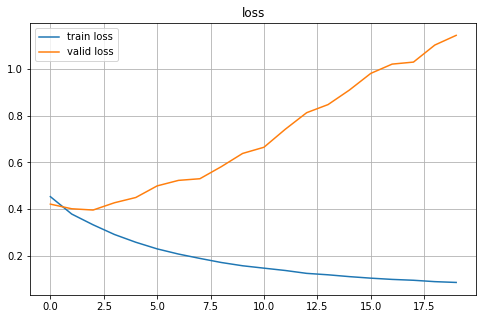

In [16]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

### [TO COMPLETE] L1 norm

One possible way to solve the overitting issue is by using regularization methods. The two most common regularization methods in Deep Learning are the L1-norm regularization and the L2-norm regularization. Both These techniques are based on limiting the capacity of models, by adding a parameter norm penalty to the objective function $\mathcal{J}$:
$$
\hat{\mathcal{J}}(\theta,\mathbf{X},\mathbf{y}) = \mathcal{J}(\theta,\mathbf{X},\mathbf{y}) + \alpha \Omega(\theta)
$$
where $\alpha$ is a hyperparameter that weighs the relative contribution of the norm penalty $\Omega$.
Lets start by considering the L1-norm regularization where the regularization term is defined as:
$$
 \Omega(\theta)=||\mathbf{W}||_1=\sum_i |\mathbf{w}|
$$
Let's find the values for the $\alpha$ parameters that allow to remove the overfitting effect.

Epoch 1/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.6497 - accuracy: 0.8272 - val_loss: 0.5855 - val_accuracy: 0.8433
Epoch 2/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5640 - accuracy: 0.8444 - val_loss: 0.5440 - val_accuracy: 0.8497
Epoch 3/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5363 - accuracy: 0.8497 - val_loss: 0.5402 - val_accuracy: 0.8472
Epoch 4/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.5297 - accuracy: 0.8495 - val_loss: 0.5396 - val_accuracy: 0.8461
Epoch 5/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.5252 - accuracy: 0.8504 - val_loss: 0.5304 - val_accuracy: 0.8497
Epoch 6/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.5233 - accuracy: 0.8507 - val_loss: 0.5217 - val_accuracy: 0.8499
Epoch 7/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.5179 - accuracy: 0.8512 - val_loss: 0.5348 - val_accu

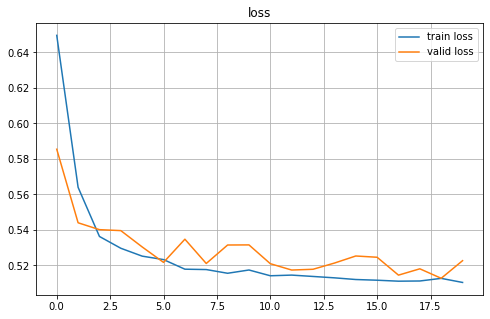

In [17]:
#In Keras is neccesary to add the regularizer by using the attribute kernel_regularizer
#to each layer whose weights will be considered in the Omega function.
#is it also possibile to consider the bias by using the attribute bias_regularizer 
#tf.keras.regularizers.l1(alpha) perfroms the L1-norm regularization

#[TO COMPLETE] copy the model that you previously defined that overfits the 
#training data, and add the L1-norm regularization. Use a proper value for the
#alpha hyper-parameter, that prevents the model from overfitting. The results  
#reached by the model in terms of loss and accuracy (in all data sets) should be
#comparable with the ones obtained by the initial model defined in Exercise 2.1 

#In general, a layer that exploits L1-norm regularization is defined as follows:

#model.add(keras.layers.Dense(units=[TO COMPLETE], activation=[TO COMPLETE], kernel_regularizer=tf.keras.regularizers.l1([TO COMPLETE]))) 

alpha = 0.0001

model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(alpha)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(alpha)),
    keras.layers.Dense(4, activation="softmax")
])#[TO COMPLETE]

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"]) #[TO COMPLETE] learning rate

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #[TO COMPLETE] epochs


print("Model Evaluation")
model.evaluate(X_test, y_test)
plot_learning_curves(history)

### [TO COMPLETE] L2-norm

L2-norm regularization is also known as weight decay. This strategy drives the weights closer to the origin by adding the regularization term omega which is defined as:
$$
 \Omega(\theta)=\frac{1}{2}||\mathbf{W}||_2^2
$$

Let's find the values for the $\alpha$ parameters that allow removing remove the overfitting effect with L2-norm.

Epoch 1/20
3375/3375 [==============================] - 10s 3ms/step - loss: 0.5944 - accuracy: 0.8219 - val_loss: 0.5459 - val_accuracy: 0.8372
Epoch 2/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5297 - accuracy: 0.8370 - val_loss: 0.5193 - val_accuracy: 0.8395
Epoch 3/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5170 - accuracy: 0.8398 - val_loss: 0.5171 - val_accuracy: 0.8401
Epoch 4/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5137 - accuracy: 0.8386 - val_loss: 0.5181 - val_accuracy: 0.8372
Epoch 5/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5117 - accuracy: 0.8396 - val_loss: 0.5232 - val_accuracy: 0.8343
Epoch 6/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5098 - accuracy: 0.8401 - val_loss: 0.5113 - val_accuracy: 0.8399
Epoch 7/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5086 - accuracy: 0.8400 - val_loss: 0.5174 - val_accuracy

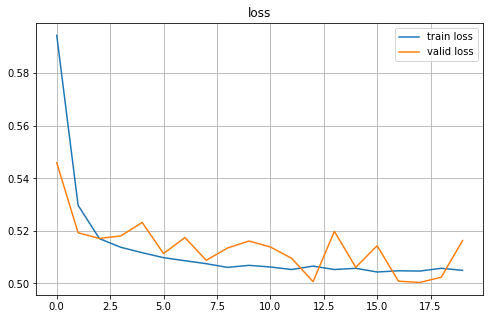

In [18]:
#[TO COMPLETE] insert the model that you previously defined that overfit the 
#trainig data, and add the L2-norm regularization. Use proper values for the
#alpha hyper-parameters, that prevents the model from overfitting. The results  
#reached by the model in terms of loss and accuracy (in all data sets) should be
#comparable with the ones obtained by the initial model defined in Exercise 2.1

#In general, a layer that exploits L2-norm regularization is defined as follow:

#model.add(keras.layers.Dense(units=[TO COMPLETE], activation=[TO COMPLETE],kernel_regularizer=tf.keras.regularizers.l2([TO COMPLETE]))) 

alpha = 0.0005

model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    keras.layers.Dense(4, activation="softmax")
])#[TO COMPLETE]

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"]) #[TO COMPLETE] learning rate

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #[TO COMPLETE] epochs


print("Model Evaluation")
model.evaluate(X_test, y_test)
plot_learning_curves(history)

###[TO COMPLETE] Early stopping

Early Stopping is a form of regularization used to avoid overfitting. It is designed to monitor the generalization error of one model and stop training when generalization error begins to degrade. In order to evaluate the generalization error, early stopping requires that a validation dataset is evaluated during training. Then, when the validation error does not improve for a specific number of epochs (`patience` hyper-parameter), it stops the training phase.

Epoch 1/20
3375/3375 [==============================] - 9s 3ms/step - loss: 0.4534 - accuracy: 0.8350 - val_loss: 0.4210 - val_accuracy: 0.8506
Epoch 2/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.3777 - accuracy: 0.8630 - val_loss: 0.4031 - val_accuracy: 0.8569
Epoch 3/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.3278 - accuracy: 0.8804 - val_loss: 0.4015 - val_accuracy: 0.8584
Epoch 4/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2864 - accuracy: 0.8965 - val_loss: 0.4225 - val_accuracy: 0.8553
Epoch 5/20
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2501 - accuracy: 0.9089 - val_loss: 0.4510 - val_accuracy: 0.8510
Model Evaluation
238/238 [==============================] - 1s 2ms/step - loss: 0.4122 - accuracy: 0.8553


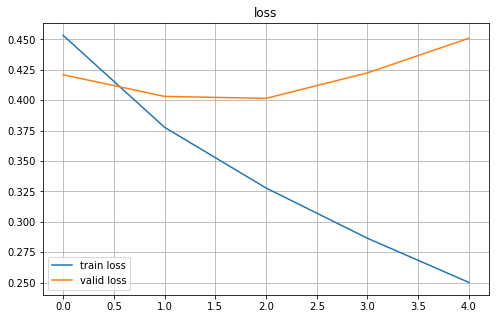

In [19]:
#[TO COMPLETE] insert the model that you previously defined that overfit the 
#trainnig data
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])#[TO COMPLETE]

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy"]) #[TO COMPLETE] learning rate



#Let's define a log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

#In Keras the early stopping is manage by using the callbacks argument.
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=2),#[TO COMPLETE] play with patience and find the value that prevents the model from overfitting.


    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

history = model.fit(X_train, y_train, epochs=20,#[TO COMPLETE] epochs
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

print("Model Evaluation")
#The early stopping stopped training after few epochs without progress, so your
#model may already have started to overfit the training set. Since the 
#ModelCheckpoint callback only saved the best models (on the validation set) the
#last saved model is the best on the validation set.
model = keras.models.load_model("my_mnist_model.h5")
model.evaluate(X_test, y_test)
plot_learning_curves(history)


## Exercise 2.3: Model Selection

Hyperparameters are the parameters of the learning method itself which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit (the network weights). The aim of model selection is selecting the best hyperparameters for our deep network. Finding the right hyperparameters for a model can be crucial for the model performance on given data. For istance lets consider our model trained by using different values for the learning rate: 

In [20]:
learning_rates = [1e-4, 1e-2, 1e-1]

In [21]:
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
                                    tf.keras.Input(shape=(num_words,)),
                                    keras.layers.Dense(16, activation="relu"),
                                    keras.layers.Dense(16, activation="relu"),
                                    keras.layers.Dense(4, activation="softmax")
                                     ])
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
              
    callbacks = [keras.callbacks.EarlyStopping(patience=2)]

    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid), epochs=10,
                        callbacks=callbacks)
    histories.append(history)
    print("evaluation on test set")
    model.evaluate(X_test, y_test)

Epoch 1/10
3375/3375 [==============================] - 8s 2ms/step - loss: 0.8467 - accuracy: 0.6874 - val_loss: 0.5046 - val_accuracy: 0.8340
Epoch 2/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4544 - accuracy: 0.8446 - val_loss: 0.4450 - val_accuracy: 0.8475
Epoch 3/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4203 - accuracy: 0.8537 - val_loss: 0.4310 - val_accuracy: 0.8498
Epoch 4/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.4071 - accuracy: 0.8567 - val_loss: 0.4227 - val_accuracy: 0.8508
Epoch 5/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3996 - accuracy: 0.8588 - val_loss: 0.4193 - val_accuracy: 0.8516
Epoch 6/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3944 - accuracy: 0.8601 - val_loss: 0.4160 - val_accuracy: 0.8524
Epoch 7/10
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3904 - accuracy: 0.8612 - val_loss: 0.4137 - val_accuracy:

Let's plot the results

Learning rate: 0.0001


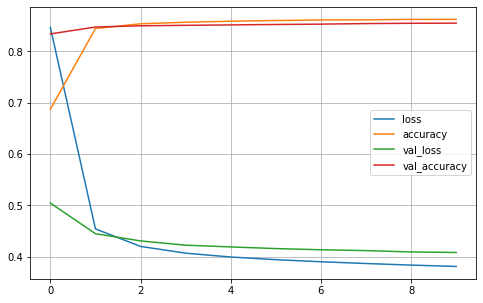

Learning rate: 0.01


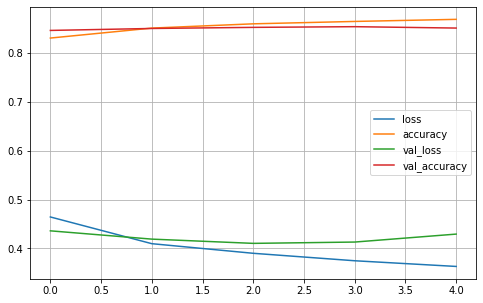

Learning rate: 0.1


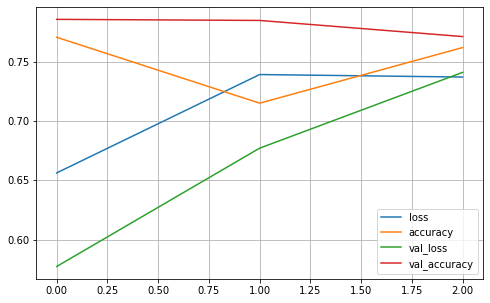

In [22]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_acc_and_loss(history)

### [TO COMPLETE] GRID Search:

Since a deep net has many hyperparameters, in order to find the best ones, we have to consider all the possible combinations of all of the possible values. One common method to perform this complex task is Grid-Search.
Given a set of values for each hyper-parameter, Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. Finally, the model that obtained the best result on the validation set will be select.

In order to perfrom Grid-Search we will use the `GridSearchCV` class from `scikit-learn`.

Let's Create a `build_model()` function that takes two arguments, `n_neurons` and `learning_rate`, and builds, compiles and returns a model with the given number of of neurons and the given learning rate.
In order to limit the time requirements of the process we will consider only these two hyper-paramters.

[TO COMPLETE] in the following code cell define the `build_model` function.

In [23]:
def build_model(n_units=30, learning_rate=1e-3):
    # The function has to build a model similar to the ones we used in previuous execises:
    #- a input layer 
    #- one or two Dense layers composed of n_units and that exploit Relu activation function 
    #- the output layer that uses the softmax activation function
    # Then, the model has to be compiled.

    model = keras.models.Sequential([
        tf.keras.Input(shape=(num_words,)),
        keras.layers.Dense(n_units, activation="relu"),
        keras.layers.Dense(n_units, activation="relu"),
        keras.layers.Dense(4, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
    
    # [TO COMPLETE] Then, the model has to be compiled.
    
    return model

    
#Create a keras.wrappers.scikit_learn.KerasRegressor and pass the build_model 
#function to the constructor. This gives you a Scikit-Learn compatible predictor
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Let's define the lists of hyper-parameters' values. Also in this case, we use a very limited size lists, but in a real-world scenario a reasonable amount of possible values should be considered (try to add some values and check how much the time required to perform the Grid-Search increases)

In [24]:
param_distribs = {
    "n_units": [8, 16],# [TO COMPLETE] insert a list that contains few (2 or 3) reasonable value
    "learning_rate": [1e-4, 1e-3] #[TO COMPLETE] insert a list that contains few (2 or 3) reasonable values
    #Check how the time required to perform GRID search increases when increasing the number of values for each hyper-parameter.
}

Use a `sklearn.model_selection.GridSearchCV` to search the hyperparameter space of your `KerasRegressor`

In [25]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(keras_reg, param_distribs)

Run the Grid-Search

In [26]:

grid_search.fit(X_train.numpy(), y_train.numpy(), epochs=5,#The number of epochs can be modified (check what happens by increasing it)
                validation_data=(X_valid.numpy(), y_valid.numpy()))

Epoch 1/5
2700/2700 [==============================] - 6s 2ms/step - loss: 1.0873 - accuracy: 0.5960 - val_loss: 0.7363 - val_accuracy: 0.7914
Epoch 2/5
2700/2700 [==============================] - 5s 2ms/step - loss: 0.5876 - accuracy: 0.8178 - val_loss: 0.5222 - val_accuracy: 0.8277
Epoch 3/5
2700/2700 [==============================] - 6s 2ms/step - loss: 0.4819 - accuracy: 0.8373 - val_loss: 0.4773 - val_accuracy: 0.8382
Epoch 4/5
2700/2700 [==============================] - 5s 2ms/step - loss: 0.4494 - accuracy: 0.8460 - val_loss: 0.4581 - val_accuracy: 0.8426
Epoch 5/5
675/675 [==============================] - 1s 2ms/step - loss: 0.4321 - accuracy: 0.8494
Epoch 1/5
2700/2700 [==============================] - 6s 2ms/step - loss: 0.9718 - accuracy: 0.6420 - val_loss: 0.6527 - val_accuracy: 0.7985
Epoch 2/5
2700/2700 [==============================] - 6s 2ms/step - loss: 0.5531 - accuracy: 0.8241 - val_loss: 0.5075 - val_accuracy: 0.8319
Epoch 3/5
2700/2700 [======================

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd60e7de790>,
             param_grid={'learning_rate': [0.0001, 0.001], 'n_units': [8, 16]})

Print the best hyper-parameters, and evealuate the best model on the test set.

In [27]:
print(grid_search.best_params_)

model = grid_search.best_estimator_.model
model.evaluate(X_test, y_test)

{'learning_rate': 0.001, 'n_units': 16}
238/238 [==============================] - 1s 2ms/step - loss: 0.3978 - accuracy: 0.8547


[0.39778804779052734, 0.854736864566803]